# Fruit Images Classification

The following task comes from the following Kaggle Fruits dataset : https://www.kaggle.com/moltean/fruits

In [167]:
#
%reload_ext autoreload
%autoreload 2

%matplotlib inline

### Importing main libraries
We import all the useful libraries from the fastai library.
The fastai library is a PyTorch wrapper containg a list of best practices. You can download the library by doing the following steps.

In [168]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Main parameters
We define :
- the path containing all our images (*PATH*)
- the size of our input images(*sz*). Here 100*100
- the architecture used. Here we use a resnext50 model trained on ImageNet
- the size of our mini batches (*bs*). Here 32

In [169]:
PATH = 'data/'
sz = 100
# architecture used
arch = resnext50
bs = 32

### Path Directories

The following code gives us a list of all directories contained in our path.
- 'Training' : Contains all our training Images.
- 'Validation' Contains all our validation images.

Please note that inside Training/Validation folders all classes of images are separated into different folders.

Note : If you have already runned this notebook once you may also find the following two folders :
- models : Containing the model of deep neural networks.
- tmp : Containing the results of pretrained layers from our model. (*See below for more information*)

In [170]:
#list of directories in PATH
os.listdir(PATH)

['models', 'tmp', 'Training', 'Validation']

### tfms_from_model
The tfms_from_model function is a fastai built-in preprocessing tool, allowing us to-do real time data augmentation by creating a list of transformation to apply to the images.
It needs :
- the architecture of the model used. (*arch*)
- the size of the images (*sz*)
- a list of transformation to apply (*aug_tfms*)
- a type of croping for the image (*crop_type*)
- a maximum zoom range (*max_zoom*)

(it is also possible to pad the data(*pad*), by choosing a padding mode (*pad_mode*), that we won't be using here)


In our following case, the function will do the followings steps : 
- Normalize the data
- Transform the images with side-on flipping but also top-down flipping as fruits can been seen in 360 degrees
- Zoom images randomly up to 1.1x normal size
- We choose to not crop the images as images are already in a square format, and well centered, according to the procedure used to create the dataset
- return a **tfms** object containing all our transformations

### ImageClassifierData
We then define a data generator containing all of our original data from training and validation sets but also our augmented data (for the training set only). This data generator is defined from the paths (*from_paths*).
- *PATH* contains the path of our data
- *bs* contains the size of our batch sizes
- *tfms* object containing the transformations to apply (*see above*)
- *trn_name* : name of our traning set folder
- *val_name* : name of our validation set folder

In [171]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_top_down, max_zoom = 1.1, crop_type=CropType.NO)
data = ImageClassifierData.from_paths(PATH, bs = bs, tfms=tfms, trn_name="Training", val_name='Validation')

#### Generation information about our data and data analysis
Our *data* object also contains information about our data.

In [172]:
#Give the number of classes
data.c

64

In [173]:
#Name of our 4 first classes
data.classes[:4]

['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3']

In [174]:
#Number of pictures in the traning set and in the validation set
data.trn_ds.n, data.val_ds.n

(31688, 10657)

The validation set represents one-third of the training set and contains enough 10657 images, which will allow us to have a good confidence and good precision in the accuracy of our model.

In [175]:
#Indicate for each picture to which class it belongs
data.trn_y

array([ 0,  0,  0, ..., 63, 63, 63])

<BarContainer object of 64 artists>

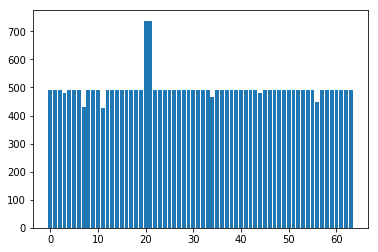

In [176]:
#We build a dictionary giving us the number of images per class in the training set 
unique, counts = np.unique(data.trn_y, return_counts=True)
fr_count_trn = dict(zip(unique, counts))
plt.bar(fr_count_trn.keys(), fr_count_trn.values())

We observe that globally the distribution of images per classes is relatively regular. We don't need to perform some preprocessing to equilibrate this distribution.

<BarContainer object of 64 artists>

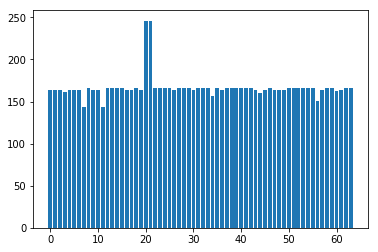

In [177]:
#We build a dictionary giving us the number of images per class in the validation set 
unique, counts = np.unique(data.val_y, return_counts=True)
fr_count_val = dict(zip(unique, counts))
plt.bar(fr_count_val.keys(), fr_count_val.values())

We observe that the validation countains a distribution similar to the one of the training set and thus is regular too. And we also have sufficient validation images for each class.

## Learning Rate Finder (LRF)

One of the feature included by the fastai is a learning rate finder. This is done by exponentially increasing the learning rate after each minibatch iteration. Thus we can plot the loss correlation with the learning rate, to find an optimal learning rate.
A good description and explanation of this technique can be found here : https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

In [178]:
#Read in images and their labels given as sub-folder names
learn = ConvLearner.pretrained(arch, data, precompute = True)
lrf = learn.lr_find()

 74%|███████████████████████████████████████████████████▏                 | 735/991 [00:30<00:10, 24.49it/s, loss=1.13]

We observe that the learning rate gradually increases after each minbatch iteration

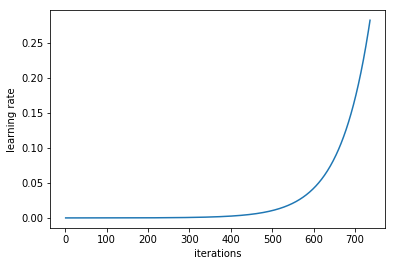

In [179]:
learn.sched.plot_lr()

The following code show us that the loss stop to decrease for a learning rate close to 1e-1. Therefore, this point show us a learning rate where the loss isn't increasing anymore. Thus we decide to take a slightly lower learning rate where the loss have slightly improvement: 1e-2. The number choosen remains quite high because we will be using a Cyclinal Learning Rate. https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0 

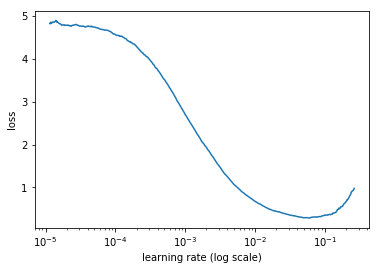

In [180]:
learn.sched.plot()

### Training

Then here we start the traning. It will be divided into 3 parts.

As we are using the __resnext50__ https://github.com/facebookresearch/ResNeXt 

By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.

- __precompute = True__ : it means that the learner will be using prelearned activations for each learner. When the precompute parameter is True, data augmentation is not enabled (no transformations), we will see why.
    
The first time we train our model with precompute = True, the frozen layers will be calculated with the weights of the ResNext architecture trained on ImageNet. Thus, if we train this network, the results from the activations of the frozen layers will always remain the same for each epoch. 

Instead of recalculating each time these activations, we can store them (saved in the tmp folder inside the PATH) to save computational power and time. This is done with __Precompute = True__.
Likewise, if we restart the notebook as the prelearned activations are already save it will use them to speed our fitting process.

Note : That precompute cannot be activated with data augmentation and without layer freezing.


## 4 Fit
Our fit function take in two parameters :
- the learning rate : 1e-2 as determined by our learning rate finder
- the number of cycles( this term will be explained below) : here equal to the number of epochs : 1 epoch

1 epoch is enough here as our model is already overfitting.

In [163]:
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.051082   0.08325    0.97701   


[array([0.08325]), 0.9770104156892183]

### Precompute = False
We then fit the last layers by disabling Precompute. This enable data augmentation as defined in our transformation object.
It is not possible to use prelearned activations as for each epochs the augmentations are randomly selected.
This gives us more accurate weights for the last layer of our model.

In [13]:
learn.precompute=False

### Stochastic Gradient with Restart (SGDR)

In [14]:
learn.fit(5e-3, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.075451   0.086569   0.972506  
    1      0.054968   0.076143   0.973726                     
    2      0.046704   0.072031   0.977573                     


[array([0.07203]), 0.9775734259172375]

### Unfreeze all layers

In [15]:
learn.unfreeze()

### Differential learning rate

In [16]:
lr=np.array([5e-5, 5e-4, 5e-3])

In [17]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.029371   0.032549   0.984611  
    1      0.017866   0.02732    0.987614                     
    2      0.017797   0.026553   0.987614                     
    3      0.017111   0.029747   0.986769                     
    4      0.016845   0.028255   0.986488                     
    5      0.016368   0.026623   0.988458                     
    6      0.017663   0.027019   0.98874                       


[array([0.02702]), 0.9887397954396172]

### Save Model

In [18]:
learn.save('model_resnext50')

In [194]:
learn.load('model_resnext50')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([4096]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

### Testing Time Augmentation
Testing Time Augmentation (TTA) does augmentation on the validation set. Thus we take the mean of the augmented images to determine the final prediction. 

In [190]:
#PyTorch by default give the log of predications
log_preds,y = learn.TTA()

#Thus we use the exponential function to obtain the predictions, then we choose the mean of the augmented images to obtain our final probabilities per class
probs = np.mean(np.exp(log_preds),0)

In [191]:
#We select the argmax of the probs to determine which class is our prediction (have the highest probability)
preds = np.argmax(probs, axis = 1)

In [23]:
#Calculate our final accuracy after testing time augmentation
accuracy_np(probs, y)

0.9887397954396172

In [24]:
#Define a function which return n_ex distincts numbers (here means examples) from one mask
def rand_by_mask(mask,n_ex): return np.random.choice(np.where(mask)[0], n_ex, replace=False)

In [25]:
#This function use previous function and return 4 examples corresponding to correct classfication(correct or wrong)
def rand_by_correct(is_correct, n_ex): return rand_by_mask((preds == data.val_y)==is_correct, n_ex)

In [26]:
#Define a plot function
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [27]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [28]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [f'{np.max(probs[x],0)}\nPred : {data.classes[np.argmax(probs[x],0)]}\nActual : {data.classes[y[x]]}' for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [193]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True,5),"Correctly classified")

NameError: name 'plot_val_with_title' is not defined

We observe that for the correctly classified images, the probability seems to really high. This indicates, that our classifier have a high confidence in his correct predictions.

Incorrectly classified


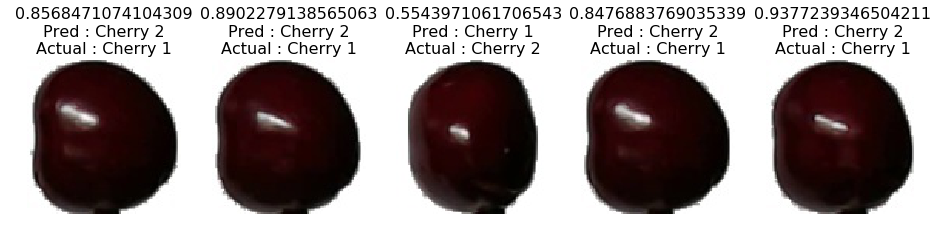

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False,5), "Incorrectly classified")

We observe that our model seems to have difficulties to distinguish Cherry Type 1 from Cherry Type 2. From an human point of view the differences between both types seems to be hard to determine.

### Confusion Matrix

We decide to plot a confusion matrix to determine what are the main confusion made by the classifier.

In [195]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


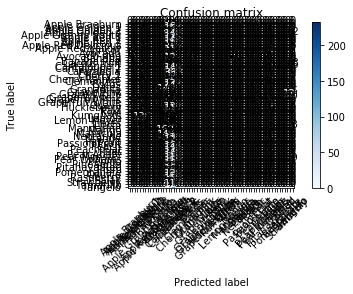

In [196]:
plot_confusion_matrix(cm, data.classes)

Due to an high number of classes (64), the previous confusion matrix is difficult to read.Therefore, a lots of the cases seems to be 0 or fully correct. We create an array containing all the misclassified images in the validation set.

In [197]:
confus=[]
for i in range(cm.shape[0]):
    tot=np.sum(cm,1)[i]
    for j in range(cm.shape[0]):
        if cm[i,j]!=0 and cm[i,j]!=tot and data.classes[i]!=data.classes[j]:
            confus.append([cm[i,j], tot, round(cm[i,j]/tot,2), data.classes[i],data.classes[j]])
confus_arr = np.array(confus)

In [36]:
confus_arr

array([['1', '164', '0.01', 'Apple Granny Smith', 'Apple Golden 3'],
       ['56', '164', '0.34', 'Cherry 1', 'Cherry 2'],
       ['60', '246', '0.24', 'Cherry 2', 'Cherry 1'],
       ['3', '166', '0.02', 'Pepino', 'Grape White']], dtype='<U32')

We can observe that most of the misclassified fruits, come from a confusion Cherry of type 1 and Cherry of type 2

[[108  56]
 [ 60 186]]


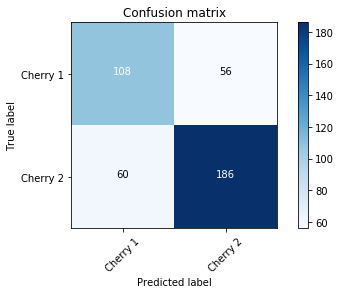

In [37]:
plot_confusion_matrix(cm[19:21,19:21], data.classes[19:21])

There is several ways to handle this problem :
- First we should check if the validation dataset is sane, after a rapid check on both classes, it seems some images are abnormally similar (even maybe identical). A rapid comparison of images of these two classes could help us to determine if there is a duplicate problem. We can also discuss with the authors of the dataset about its integrity.
- If the dataset is sane : we can increase the number of images of these 2 types of cherries or make a classifier specialized on distinguishing these two types oh cherries an use Ensemble methods.
